In [42]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from fiona.crs import from_epsg
import sys
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Config handling

In [2]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [3]:
# Get the required info from the config file
data_path     = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path  = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name  = cs.read_from_config(config_file,'cs_meta_name')
cs_unusable_name = cs.read_from_config(config_file,'cs_unusable_name')

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')

# Merged shape
merged_shape_folder = cs.read_from_config(config_file, 'merged_shp_dir')
merged_shape_name   = cs.read_from_config(config_file, 'merged_shp_name')

# Projection
img_crs =  cs.read_from_config(config_file, 'equal_area_crs')

# Image output folder
image_folder = cs.read_from_config(config_file, 'image_path')

In [4]:
# Specify the paths
merged_shape_path = Path(data_path) / cs_basin_folder / merged_shape_folder
merged_shape_path.mkdir(parents=True, exist_ok=True)

basin_path = Path(data_path) / cs_basin_folder / 'basin_data' # This should exist at this point of the workflow

image_path = Path(image_folder)
image_path.mkdir(exist_ok=True, parents=True)

### Data loading

In [6]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name, dtype={'Station_id': object})

# Open list of unusable stations; Enforce reading IDs as string to keep leading 0's
cs_unusable = pd.read_csv(cs_meta_path / cs_unusable_name, dtype={'Station_id': object})

# Attributes
cs_att_path = Path(data_path) / cs_meta_path / 'camels_spat_attributes.csv'
cs_att = pd.read_csv(cs_att_path,low_memory=False)

In [8]:
# Transpose the attributes for easier merging with GDF
cs_att = cs_att.transpose()
headers = cs_att.iloc[1] # we just keep the attribute name because with multiple header levels the merging fails
cs_att = cs_att.iloc[4:]
cs_att.columns = headers.values.tolist()

### Create the merged shape
We want the following attributes:
- Climate
    - Long-term aridity and fraction snow
    - Standard deviation of both in space (WorldClim) and time (ERA5)

#### Create a geodataframe we'll re-use for plotting

In [10]:
# Loop over the metadata to find -all- the lumped shapes
geometries = []
for ix,row in cs_meta.iterrows():
    
    # Construct the path to the lumped shapefile
    basin_str = '_'.join([row['Country'],row['Station_id']])
    lumped_shp = basin_path / basin_str / 'shapefiles' / 'lumped' / (basin_str + '_lumped.shp')
    
    # Open the shape and get the geometry
    shp = gpd.read_file(lumped_shp)
    geometries.append(shp.geometry.values[0])

In [11]:
# Get the attributes from the metadata
meta_attributes = cs_meta[['Country','Station_id','Station_name']].copy()

In [13]:
# Add the geometries
meta_attributes['geometry'] = geometries

In [15]:
# Convert to GeoDataframe
gdf = gpd.GeoDataFrame(meta_attributes, crs=None)

In [16]:
# Set the CRS
gdf.crs = from_epsg(4326)

/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/proj/9.0.0/lib/python3.10/site-packages/pyproj-3.3.0-py3.10-linux-x86_64.egg/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [17]:
# Remove the stations we don't want
not_these = cs_unusable['Station_id'].unique() # we have some duplicates in here, this removes those
gdf = gdf[~gdf['Station_id'].isin(not_these)]
gdf = gdf.reset_index(drop=True)

In [18]:
# Create the variable we'll use for merging: <country>_<id>
gdf['basin_id'] = gdf.apply(lambda row: row['Country'] + '_' + row['Station_id'], axis=1)

In [19]:
# Project the basins into the projection we want for this graphic
gdf = gdf.to_crs(img_crs)

In [20]:
# Convert the polygons to point locations - these make for better plots when the figure is smaller
gdf['geometry'] = gdf['geometry'].centroid

#### Add the geospatial attributes we're interested in

In [127]:
# Climate
att_columns = ('aridity1_mean','aridity1_std','aridity2_std','fracsnow1_mean','fracsnow1_std','fracsnow2_std')
gdf_clim = pd.merge(gdf, cs_att.loc[:,att_columns].astype('float'), left_on='basin_id', right_on=cs_att.index)

In [23]:
# Veg & land use
att_columns = ('forest_height_2020_mean', 'forest_height_2020_std', 'lai_mean_month_02', 'lai_mean_month_08')
gdf_veg = pd.merge(gdf, cs_att.loc[:,att_columns].astype('float'), left_on='basin_id', right_on=cs_att.index)

In [24]:
# Topography
att_columns = ('elev_mean', 'elev_std', 'stream_length_mean', 'stream_length_std','open_water_area_total', 'open_water_volume_total', 'basin_area')
gdf_topo = pd.merge(gdf, cs_att.loc[:,att_columns].astype('float'), left_on='basin_id', right_on=cs_att.index)
gdf_topo['open_water_area_frac'] = gdf_topo['open_water_area_total'] / gdf_topo['basin_area'] # better for plotting to use fractions

In [25]:
# Subsurface
att_columns = ('sand_0-5cm_mean_mean','sand_0-5cm_mean_std','sand_0-5cm_uncertainty_mean','sand_0-5cm_uncertainty_std',
               'sedimentary_thickness_mean','sedimentary_thickness_std')
gdf_sub = pd.merge(gdf, cs_att.loc[:,att_columns].astype('float'), left_on='basin_id', right_on=cs_att.index)

In [62]:
# Hydrology
att_columns = ('daily_discharge_mean','daily_discharge_std','daily_streamflow_mean_month_05','daily_streamflow_mean_month_12',
               'no_flow_dur_mean','no_flow_dur_skew','low_flow_dur_mean','low_flow_dur_skew','high_flow_dur_mean','high_flow_dur_skew')
gdf_hyd = pd.merge(gdf, cs_att.loc[:,att_columns].astype('float'), left_on='basin_id', right_on=cs_att.index)

### Figures
We'll also add some nation, state, province and territory boundaries (CEC, 2022). This is a pretty hefty download so we'll exclude these files from the repo and simply build in a flag below to not plot the background shapes if they are not available on the system.

**Reference**

Commission for Environmental Cooperation (CEC). 2022. “North American Atlas – Political Boundaries”. Statistics Canada, United States Census Bureau, Instituto Nacional de Estadística y Geografía (INEGI). Ed. 3.0, Vector digital data [1:10,000,000]. Available at http://www.cec.org/north-american-environmental-atlas/political-boundaries-2021/. Accessed 2023-12-20

In [28]:
border_path = cs_meta_path / 'TEMP_PoliticalBoundaries_Shapefile/NA_PoliticalDivisions/data/bound_p/boundaries_p_2021_v3.shp'

In [30]:
# Check if we have the boundary file and act accordingly
have_borders = False
if os.path.exists(border_path):
    have_borders = True
    gdf_borders = gpd.read_file(border_path)
    gdf_borders = gdf_borders.to_crs(img_crs)

#### Generalized plotting function

In [31]:
def disable_box_boundaries(ax):
    ax.set_xlim([-2.5*1e6, 3.1*1e6])
    ax.set_ylim([-1.6*1e6, 3.7*1e6])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [81]:
def add_histogram(ax,bbox,gdf,column,bar_scale,bins=10,extra=None):
    # Make the extra axis
    hax = inset_axes(ax, width='100%', height='100%', bbox_to_anchor=bbox, bbox_transform=ax.transAxes, loc=4)
    
    # Add the histogram
    gdf[column].plot.hist(ax=hax, color='0.3', rwidth=bar_scale, bins=bins)#, edgecolor='w')

    # Disable top, right, and bottom spines
    hax.spines['top'].set_visible(False)
    hax.spines['right'].set_visible(False)
    hax.spines['left'].set_visible(False)

    # (Re)move y-axis ticks and labels
    hax.set_ylabel('')
    hax.set_yticks([])
    hax.set_yticklabels([]);

    # Category-specific modifications:
    if extra == 'sand_content':
        hax.set_xticks([250,500,750])
        hax.set_xticklabels(['250','','750'])
    elif extra == 'sand_std':
        hax.set_xticks([50,100,150])
        hax.set_xticklabels(['50','','150'])
    elif extra == 'pet_mean':
        hax.set_xticks([250,500,750])
        hax.set_xticklabels(['250','','750'])
    
    return

In [33]:
legend_scale = 0.6
legend_kwds = {'shrink':legend_scale,
               'orientation': 'horizontal', 
               'pad': 0.01}
poly_width = 0.1
poly_edge = 'k'
markersize = 10

map_color = '0.65'

hist_loc = (.8, .075, .25, .25)
hist_bar_scale = 0.75

#### Disable deprecation warnings
```
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
```

In [38]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

#### Hydrology

/tmp/ipykernel_230335/3266818360.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


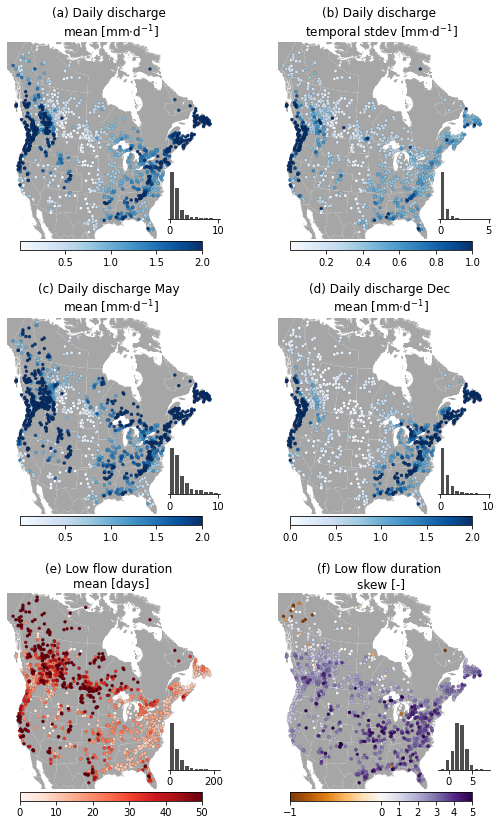

In [76]:
fig, axs = plt.subplots(3,2,figsize=(8.27,11.69))
have_borders=True

# (a) mean runoff
ax = axs[0,0]; color = 'Blues'; column = 'daily_discharge_mean'; vmax = 2
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_hyd.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax,
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_hyd,column,hist_bar_scale,bins=np.linspace(0,10, num=11))
ax.set_title('(a) Daily discharge \nmean [mm$\cdot$d$\mathregular{^{-1}}$]')

# (b) stdev runoff
ax = axs[0,1]; color = 'Blues'; column = 'daily_discharge_std'; vmax = 1
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_hyd.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_hyd,column,hist_bar_scale,bins=np.linspace(0,5, num=11))
ax.set_title('(b) Daily discharge \ntemporal stdev [mm$\cdot$d$\mathregular{^{-1}}$]')

# (c) mean May runoff
ax = axs[1,0]; color = 'Blues'; column = 'daily_streamflow_mean_month_05'; vmax = 2
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_hyd.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_hyd,column,hist_bar_scale, bins=np.linspace(0,10, num=11))
ax.set_title('(c) Daily discharge May \nmean [mm$\cdot$d$\mathregular{^{-1}}$]')

# (d) mean Dec runoff
ax = axs[1,1]; color = 'Blues'; column = 'daily_streamflow_mean_month_12'; vmax = 2
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_hyd.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_hyd,column,hist_bar_scale, bins=np.linspace(0,10, num=11))
ax.set_title('(d) Daily discharge Dec \nmean [mm$\cdot$d$\mathregular{^{-1}}$]')

# (e) low flow duration mean
ax = axs[2,0]; color = 'Reds'; column = 'low_flow_dur_mean'; vmax = 50
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_hyd.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_hyd,column,hist_bar_scale)
ax.set_title('(e) Low flow duration \nmean [days]')

# (f) low flow duration skew
ax = axs[2,1]; color = 'PuOr'; divnorm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=5); column = 'low_flow_dur_skew'; vmax = 20
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_hyd.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, norm=divnorm,
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, #vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_hyd,column,hist_bar_scale)
ax.set_title('(f) Low flow duration \nskew [-]')

plt.tight_layout()
plt.savefig(image_path / 'attributes_hydro_dots.png', dpi=300, bbox_inches='tight')

#### Soil

/tmp/ipykernel_230335/3156304997.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


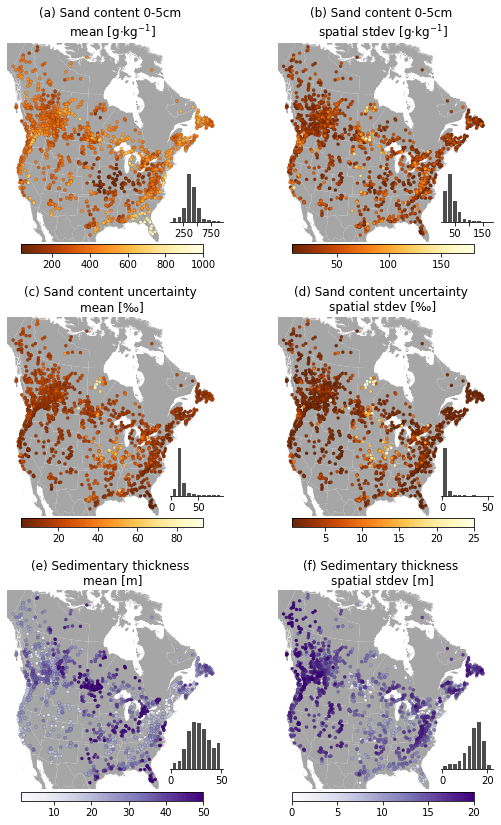

In [83]:
fig, axs = plt.subplots(3,2,figsize=(8.27,11.69))
have_borders=True

# (a) mean sand %
ax = axs[0,0]; color = 'YlOrBr_r'; column = 'sand_0-5cm_mean_mean'; vmax = 1000
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_sub.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax,
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_sub,column,hist_bar_scale,extra='sand_content')
ax.set_title('(a) Sand content 0-5cm \nmean [g$\cdot$kg$\mathregular{^{-1}}$]')

# (b) stdev sand %
ax = axs[0,1]; color = 'YlOrBr_r'; column = 'sand_0-5cm_mean_std'; vmax = 500
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_sub.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, #vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_sub,column,hist_bar_scale,extra='sand_std')
ax.set_title('(b) Sand content 0-5cm \nspatial stdev [g$\cdot$kg$\mathregular{^{-1}}$]')

# (c) sand uncertainty mean
ax = axs[1,0]; color = 'YlOrBr_r'; column = 'sand_0-5cm_uncertainty_mean'; vmax = 0.05
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_sub.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, #vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_sub,column,hist_bar_scale)
ax.set_title('(c) Sand content uncertainty \nmean [‰]')

# (d) sand uncertainty stdev
ax = axs[1,1]; color = 'YlOrBr_r'; column = 'sand_0-5cm_uncertainty_std'; vmax = 25
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_sub.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_sub,column,hist_bar_scale)
ax.set_title('(d) Sand content uncertainty \nspatial stdev [‰]')

# (e) sedimentary thickness mean
ax = axs[2,0]; color = 'Purples'; column = 'sedimentary_thickness_mean'; vmax = 20
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_sub.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, #vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_sub,column,hist_bar_scale)
ax.set_title('(e) Sedimentary thickness \nmean [m]')

# (f) sedimentary thickness stdev
ax = axs[2,1]; color = 'Purples'; column = 'sedimentary_thickness_std'; vmax = 20
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_sub.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_sub,column,hist_bar_scale)
ax.set_title('(f) Sedimentary thickness \nspatial stdev [m]')

plt.tight_layout()
plt.savefig(image_path / 'attributes_soil_dots.png', dpi=300, bbox_inches='tight')

#### Topography and open water plots
We have two version of these. The first is 6 plots and contains topography and open water. The second is 4 plots and contains only topography.

/tmp/ipykernel_230335/348044731.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


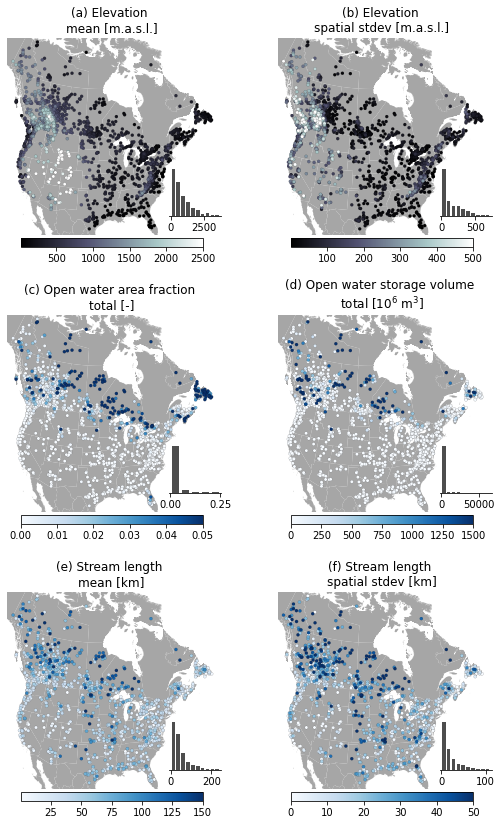

In [98]:
fig, axs = plt.subplots(3,2,figsize=(8.27,11.69))
have_borders=True

# (a) mean elev
ax = axs[0,0]; color = 'bone'; column = 'elev_mean'; vmax = 2500
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_topo.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax,
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_topo,column,hist_bar_scale)
ax.set_title('(a) Elevation \nmean [m.a.s.l.]')

# (b) space std elev
ax = axs[0,1]; color = 'bone'; column = 'elev_std'; vmax = 500
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_topo.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_topo,column,hist_bar_scale)
ax.set_title('(b) Elevation \nspatial stdev [m.a.s.l.]')

# (c) fraction open water > 0.1 ha
ax = axs[1,0]; color = 'Blues'; column = 'open_water_area_frac'; vmax = 0.05
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_topo.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_topo,column,hist_bar_scale,bins=np.linspace(0,0.25, num=6))
ax.set_title('(c) Open water area fraction \ntotal [-]')

# (d) total open water storage
ax = axs[1,1]; color = 'Blues'; column = 'open_water_volume_total'; vmax = 1500
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_topo.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)

disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_topo,column,hist_bar_scale)
ax.set_title('(d) Open water storage volume \ntotal [$\mathregular{10^{6}}$ m$\mathregular{^{3}}$]')

# (e) mean stream length
ax = axs[2,0]; color = 'Blues'; column = 'stream_length_mean'; vmax = 150
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_topo.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_topo,column,hist_bar_scale)
ax.set_title('(e) Stream length \nmean [km]')

# (f) spatial std stream length
ax = axs[2,1]; color = 'Blues'; column = 'stream_length_std'; vmax = 50
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_topo.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_topo,column,hist_bar_scale)
ax.set_title('(f) Stream length \nspatial stdev [km]')

plt.tight_layout()
plt.savefig(image_path / 'attributes_topography_dots.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(8.27,(2/3)*11.69))
have_borders=True

# (a) mean elev
ax = axs[0,0]; color = 'bone'; column = 'elev_mean'; vmax = 2500
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_topo.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax,
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_topo,column,hist_bar_scale)
ax.set_title('(a) Elevation: mean [m.a.s.l.]')

# (b) space std elev
ax = axs[0,1]; color = 'bone'; column = 'elev_std'; vmax = 500
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_topo.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_topo,column,hist_bar_scale)
ax.set_title('(b) Elevation: spatial stdev [m.a.s.l.]')

# (c) mean stream length
ax = axs[1,0]; color = 'Blues'; column = 'stream_length_mean'; vmax = 150
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_topo.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_topo,column,hist_bar_scale)
ax.set_title('(c) Stream length: mean [km]')

# (d) spatial std stream length
ax = axs[1,1]; color = 'Blues'; column = 'stream_length_std'; vmax = 50
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_topo.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_topo,column,hist_bar_scale)
ax.set_title('(d) Stream length: spatial stdev [km]')

plt.tight_layout()
plt.savefig(image_path / 'attributes_topography_dots.png', dpi=300, bbox_inches='tight')

#### Climate

/tmp/ipykernel_230335/4080985315.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


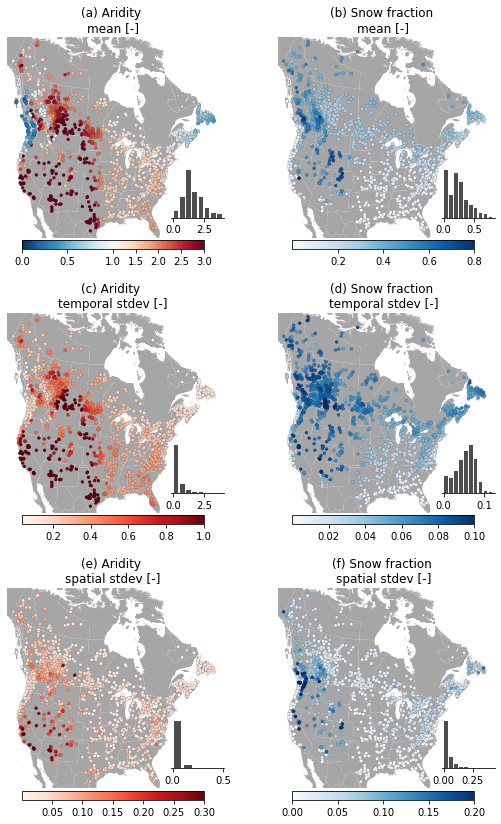

In [99]:
fig, axs = plt.subplots(3,2,figsize=(8.27,11.69))
have_borders=True

# (a) mean aridity
ax = axs[0,0]; color = 'RdBu_r'; divnorm = colors.TwoSlopeNorm(vmin=0., vcenter=1, vmax=3); column = 'aridity1_mean'
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
tmp = gdf_clim.sort_values(by=column) # Sort ascending: 0 values plotted first (at the bottom)
tmp.plot(ax=ax, column=column, markersize=markersize, 
           cmap=color, norm=divnorm, edgecolor=poly_edge, linewidth=poly_width, 
           legend=True, legend_kwds=legend_kwds) # plot the whole thing, lowest aridity at the bottom
tmp[tmp['aridity1_mean']<1].sort_values(by='aridity1_mean', ascending=False).plot(ax=ax, column=column, markersize=markersize, # add low aridity values in reverse order
                                                                                   cmap=color, norm=divnorm, edgecolor=poly_edge, linewidth=poly_width) 
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,bins=np.linspace(0,4,num=9))
ax.set_title('(a) Aridity \nmean [-]')

# (c) time std aridity
ax = axs[1,0]; color = 'Reds'; column = 'aridity1_std'; vmax = 1
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, vmax=vmax, edgecolor=poly_edge, linewidth=poly_width, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,bins=np.linspace(0,4,num=9))
ax.set_title('(c) Aridity \ntemporal stdev [-]')

# (e) space std aridity
ax = axs[2,0]; color = 'Reds'; column = 'aridity2_std'; vmax = 0.3
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, vmax=vmax, edgecolor=poly_edge, linewidth=poly_width, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,bins=np.linspace(0,0.5,num=6))
ax.set_title('(e) Aridity \nspatial stdev [-]')

# (b) mean snow fraction
ax = axs[0,1]; color = 'Blues'; column = 'fracsnow1_mean'; vmax = 0.8
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, vmax=vmax, edgecolor=poly_edge, linewidth=poly_width, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale)
ax.set_title('(b) Snow fraction \nmean [-]')

# (d) time std snow fraction
ax = axs[1,1]; color = 'Blues'; column = 'fracsnow1_std'; vmax = 0.1
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, vmax=vmax, edgecolor=poly_edge, linewidth=poly_width, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale)
ax.set_title('(d) Snow fraction \ntemporal stdev [-]')

# (f) space std snow fraction
ax = axs[2,1]; color = 'Blues'; column = 'fracsnow2_std'; vmax = 0.2
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, vmax=vmax, edgecolor=poly_edge, linewidth=poly_width, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale)
ax.set_title('(f) Snow fraction \nspatial stdev [-]')

plt.tight_layout()
plt.savefig(image_path / 'attributes_climate_dots.png', dpi=300, bbox_inches='tight')

#### Vegetation

/tmp/ipykernel_230335/3103845197.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


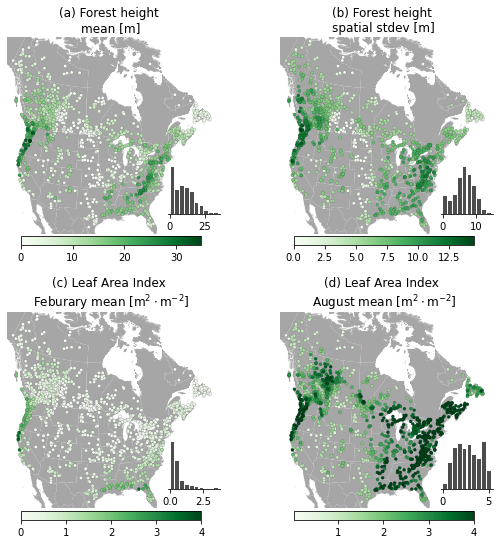

In [102]:
fig, axs = plt.subplots(2,2,figsize=(8.27,(2/3)*11.69))
have_borders=True

# (a) mean forest height
ax = axs[0,0]; color = 'Greens'; column = 'forest_height_2020_mean'
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_veg.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_veg,column,hist_bar_scale)
ax.set_title('(a) Forest height \nmean [m]')

# (b) space std forest height
ax = axs[0,1]; color = 'Greens'; column = 'forest_height_2020_std'; #vmax = 1
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_veg.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, #vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_veg,column,hist_bar_scale)
ax.set_title('(b) Forest height \nspatial stdev [m]')

# (c) Feb LAI
ax = axs[1,0]; color = 'Greens'; column = 'lai_mean_month_02'; vmax = 4
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_veg.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_veg,column,hist_bar_scale)
ax.set_title('(c) Leaf Area Index \nFeburary mean [m$\mathregular{^{2}}\cdot$m$\mathregular{^{-2}}$]')

# (d) Aug LAI
ax = axs[1,1]; color = 'Greens'; column = 'lai_mean_month_08'; vmax = 4
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_veg.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_veg,column,hist_bar_scale)
ax.set_title('(d) Leaf Area Index \nAugust mean [m$\mathregular{^{2}}\cdot$m$\mathregular{^{-2}}$]')

plt.tight_layout()
plt.savefig(image_path / 'attributes_vegetation_dots.png', dpi=300, bbox_inches='tight')

In [103]:
image_path

PosixPath('/gpfs/tp/gwf/gwf_cmt/wknoben/camels_spat/camels-spat-data/img')